In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

<figure>
<IMG SRC="images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 5: Periodigram and Leakage

<figure>
<IMG SRC="http://hornby.seos.uvic.ca/~jklymak/images/KrhoBinnedDispSpec.png" WIDTH=320 ALIGN="right" STYLE="padding-left:20px" ALT="Turbulence and internal wave spectra in the ocean">
</figure>

We saw previously that the discrete power spectral estimate is quite imprecise, with an uncertainty of a factor of almost 40, if the data is normally distributed.  This is unacceptably imprecise if you are trying to find a small-ish peak.  

As with any other time when your data is too noisy, the solution is to average the data in some ways. There are two ways to do this that are commonly used. 1) is to take your raw spectrum and smooth in frequency or 2) to take a number of spectra from adjoining windows of data and average the spectra.  (2) is called the **periodigram**, and is the focus of this lesson.

There are also issues in the finite power spectrum estimate relating to the periodicity of the data.  The assumption inherent in the power spectrum is that the signal is periodic with period $T$.  This is usually not the case, and if $T$ is small, the assumption can lead to artifacts in the spectrum.  This is called **leakage**, and can be suppressed by **windowing**


## Frequency Smoothing

An obvious, and easy, method to smooth the spectrum, is to simply smooth the spectrum in frequency.  We do this with a finite convolution, or a boxcar filter:

\begin{equation}
  \tilde{G}_{xx}\left(f_i\right) = \frac{1}{2W+1}\sum_{k=i-W}^{i+W} G_{xx}\left(f_k\right) 
\end{equation}

where here we have specified the boxcar to have width $2W+1$ frequency bins.  

To see how this works, we create a Gaussian random noise time series and add a sine wave to it:

<IPython.core.display.Javascript object>


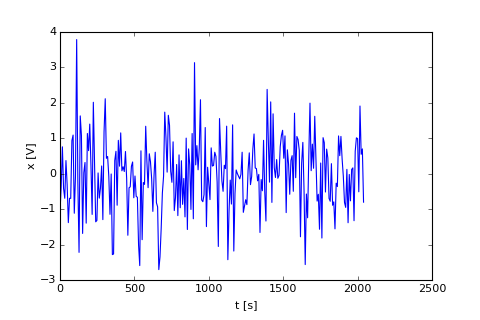

In [36]:
N= 256; T = 2048.; dt = T/N  # N samples, T is time we sample for, dt is the spacing between time samples
import scipy.stats as stats
fig,ax=plt.subplots(1,1)
t=np.arange(0,T,dt)
f0=1./100.; om = 2*np.pi*f0; amp=0.5
# noise plus sine wave
x=np.random.randn(N)+amp*np.cos(om*t)
ax.plot(t,x)
ax.set_xlabel('t [s]');ax.set_ylabel('x [V]');

Then we compute the power spectrum.  Note that the theoretical spectrum for this should consist of a "white" broadband spectrum and a delta function at $f=0.01 \mathrm{Hz}$  The white part of the spectrum should integrate so that 

\begin{equation}
    \int_{0}^{f_N} G_{xx}(f) \mathrm{d}f = 1.
\end{equation}

or

\begin{equation}
    G_{xx}(f)  = \frac{1}{f_N}
\end{equation}

where $f_N=\frac{1}{2\Delta t}$ is the Nyquist frequency.  The peak due to the sine wave should have a discrete amplitude given by 

\begin{equation}
    G_{xx}(f) = \frac{a^2}{2 \delta f}\ \delta\left(f-f_0\right)
\end{equation}

where $a$ is the amplitude of the sine wave, and $f_0$ is the frequency, and $\delta f=1/T$ is the spacing between discrete frequencies.

Having a theoretical spectrum is quite nice because we can check our response..

Then we calculate $G_{xx}(f)$ as described last lecture:

<IPython.core.display.Javascript object>


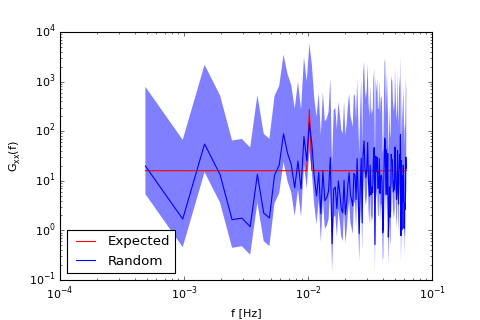

In [37]:
fig,ax=plt.subplots(1,1)

f = np.arange(N/2)/T
fN = 1./2./dt
# get the theory
Gtheory = 1./fN+0.*f
ind = np.where(f>=f0)[0][0]  # get the index of f0
Gtheory[ind]+=amp**2/2.*T
# get the spectral estimate:
X = dt*np.fft.fft(x)
G = (2./T)*np.real(np.conj(X[:N/2])*X[:N/2])
# plot
ax.loglog(f[1:],Gtheory[1:],color='r',label='Expected')
ax.loglog(f[1:],G[1:],label='Random')
ax.legend(loc=3)
# get the error bars:
inter = stats.chi2.interval(0.95,df=2)
ax.fill_between(f[1:],2.*G[1:]/inter[1],2.*G[1:]/inter[0],alpha=0.5,
                linewidth=0.0,edgecolor=None,color=None,facecolor='b')
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_{xx}(f)$')

Hopefully its clear from the above that the peak barely shows up above the variance of the spectral estimate.  Certainly it is not significant with 95% confidence.  

So we see if smoothing in frequency space can help improve the spectrum:

<IPython.core.display.Javascript object>


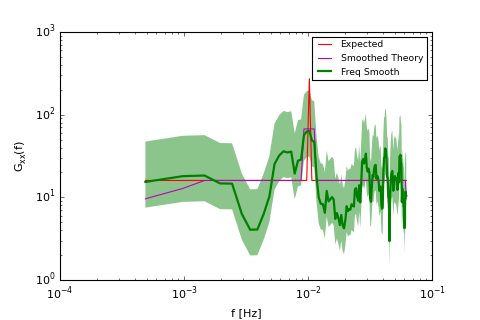

In [38]:
W=2
W=2*W+1.
fig,ax=plt.subplots(1,1)
Gsmooth=np.convolve(G[1:],np.ones(W)/W,mode='same')
ax.loglog(f[1:],Gtheory[1:],color='r',label='Expected')
Theorysmooth=np.convolve(Gtheory[1:],np.ones(W)/W,mode='same')
ax.loglog(f[1:],Theorysmooth,'m',label='Smoothed Theory')
ax.loglog(f[1:],Gsmooth,linewidth=2,label='Freq Smooth',color='g')
inter = stats.chi2.interval(0.95,df=2*W)
ax.fill_between(f[1:],2.*W*Gsmooth/inter[1],2.*W*Gsmooth/inter[0],alpha=0.45,
                linewidth=0.0,edgecolor=None,color=None,facecolor='g')
ax.legend(loc=0,fontsize='small')
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_{xx}(f)$')

Here we see that the peak is above the noise.  However, there is a cost to this, and that is that the peak is now *wider* than one frequency bin.  This shouldn't be surprising because we smoothed in frequency.  

Note that the lowest frequencies were not smoothed quite correctly using `np.convolve`. This is an edge effect of `np.convolve` and should probably be fixed in some intelligent manner.  

Note that the error bars of the smoothed spectral estimate are narrower than the raw spectral estimate.  In this case we average 5 spectral estimates, and that means we are averaging 10 squared Normal distributions:  

$$\tilde{G}_{xx}(f_k) = \frac{1}{5}\left(G_{xx}(f_{k-2})+G_{xx}(f_{k-1})+G_{xx}(f_{k})+G_{xx}(f_{k+1})+G_{xx}(f_{k+2})\right)$$ 

so this is distributed as a $\chi^2_{10}$ random variable, from which we get the error bounds pltted in green.  

So, there is an inherent tradeoff - less variance in the spectral estimate comes at the cost of poorer frequency resolution. 

## Block Averaging (Welch's Method)

Another method of decreasing the variance of the spectral estimate is to split the data up into "blocks", compute spectral estimates, and then average the spectral estimates from the blocks to create an estimate with less spectral variance.  Doing this is relatively straight forward.  Note here we make a longer time series, and make $f_0$ of our synthetic signal *higher*:

<IPython.core.display.Javascript object>


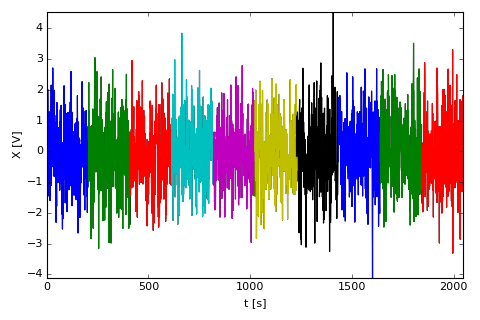

10.0


In [39]:
N= 2560
T = 2048.
dt = T/N

fig,ax=plt.subplots(1,1)
t=np.arange(0,T,dt)
f0=1./30.;    om = 2*np.pi*f0;    amp=0.5
x=np.random.randn(N)+amp*np.cos(om*t)
ax.plot(t,x,'k')
NFFT=256
# there is a better way to do this, but lets brute force it:
nblock = np.floor(N/NFFT)
print nblock
for ind in range(int(nblock)):
    inds =range(ind*NFFT,(ind+1)*NFFT)
    tblock=t[inds]
    xblock=x[inds]
    ax.plot(tblock,xblock)
ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')
plt.axis('tight')
fig.tight_layout()

Here we have coloured our 10 blocks of data that we will take independent periodigrams of.  (Note that we cannot average the data and take the periodigram and expect to get anything sensible).

Then we compute the power spectra for the 10 blocks and plot.  We will also plot the raw periodigram:

/Users/jklymak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


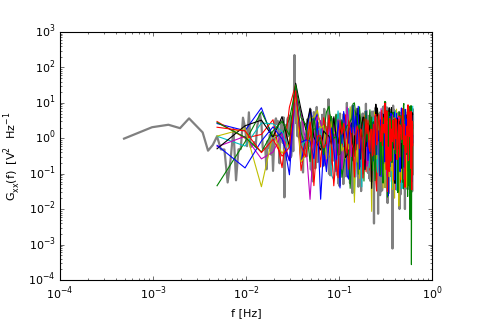

In [40]:
Gblock=np.zeros((nblock,NFFT/2))
fig,ax=plt.subplots(1,1)

# raw:
X = dt*np.fft.fft(x)
Graw = (2./T)*np.real(np.conj(X[:N/2])*X[:N/2])
f=np.arange(N/2)/T

ax.loglog(f,Graw,'0.5',linewidth=2)
# blocks:
for ind in range(int(nblock)):
    inds =range(ind*NFFT,(ind+1)*NFFT)
    tblock=t[inds]
    xblock=x[inds]
    X = dt*np.fft.fft(xblock)
    Tblock=T/nblock
    Gblock[ind,:] = (2./Tblock)*np.real(np.conj(X[:NFFT/2])*X[:NFFT/2])
    fblock= np.arange(NFFT/2)/Tblock
    ax.loglog(fblock[1:],Gblock[ind,1:])
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_{xx}(f)\ \ [V^2\,Hz^{-1}$')


By eye, it is not clear that we have improved our spectral estimate.  The individual blocks yield noisy spectra estimates. In fact it is easy to show they are just as noisy as the full spectrum.  

However, taking the average yields a much smoother spectrum.  Note the degrees of freedom is $2N_{blocks}$.

<IPython.core.display.Javascript object>


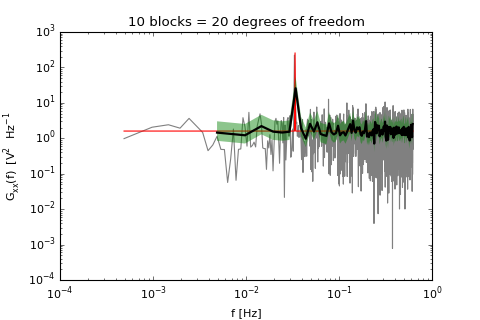

In [43]:
# make the theory spectrum:
fN=1/2./dt
Gtheory = 1./fN+0.*f
ind = np.where(f>=f0)[0][0]
Gtheory[ind]+=amp**2/2.*T

fig,ax=plt.subplots(1,1)
ax.loglog(f,Graw,color='0.5')
ax.loglog(f,Gtheory,'r')
# get error bars:
dof=2*nblock
inter = stats.chi2.interval(0.95,df=dof)
Gblockm=np.mean(Gblock,axis=0)
ax.fill_between(fblock[1:],dof*Gblockm[1:]/inter[1],dof*Gblockm[1:]/inter[0],alpha=0.45,
                linewidth=0.0,edgecolor=None,color=None,facecolor='g',zorder=3)
ax.loglog(fblock,Gblockm,'k',linewidth=2,zorder=10)
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_{xx}(f)\ \ [V^2\,Hz^{-1}$')
ax.set_title('%d blocks = %d degrees of freedom'%(nblock,2*nblock))

So, some things to note: 
   
   1. The block-spectra do not extend to as low frequencies as the raw periodigram.  This should not be surprising because the raw periodigram is taking a longer data set than the individual blocks.  Indeed $f_1=\delta f = 1/T$, so the longer $T$ the lower a frequency can be resolved.
   2. The resolution of the bloc spectra is also less than the raw.  i.e. we get the same tradeoff as smoothing in frequency - we lose frequency resolution, again because $\delta f = 1/T$.  
   
So, is this better than frequency smoothing?  The question depends on what you are trying to do and what your signal is like.  If you need the low frequency information, then the block-average method is obviously problematic.  However, as we saw above, you also need to be careful how you "average" those lower few bins.  Do they give the same result?

<IPython.core.display.Javascript object>


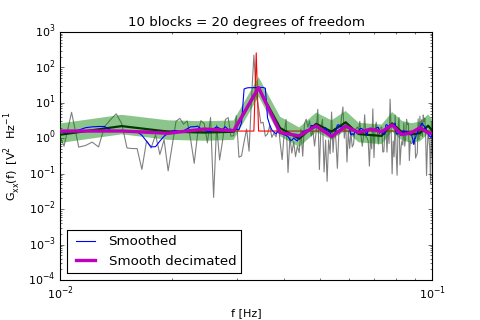

In [49]:

fig,ax=plt.subplots(1,1)
ax.loglog(f,Graw,color='0.5')
ax.loglog(f,Gtheory,'r')
# get error bars:
dof=2*nblock
inter = stats.chi2.interval(0.95,df=dof)
Gblockm=np.mean(Gblock,axis=0)
ax.fill_between(fblock[1:],dof*Gblockm[1:]/inter[1],dof*Gblockm[1:]/inter[0],alpha=0.45,
                linewidth=0.0,edgecolor=None,color=None,facecolor='g',zorder=3)
ax.loglog(fblock,Gblockm,'k',linewidth=2,zorder=2)
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_{xx}(f)\ \ [V^2\,Hz^{-1}$')
ax.set_title('%d blocks = %d degrees of freedom'%(nblock,2*nblock))
Gsmooth = np.convolve(Graw,np.ones(10)/10.,mode='same')
ax.loglog(f,Gsmooth,'b',label='Smoothed',zorder=4)
ax.loglog(f[::10],Gsmooth[::10],'m',label='Smooth decimated',zorder=5,linewidth=3)
ax.set_xlim([1e-2,1e-1])
ax.legend(loc=3)
fig.show()

There is no statistical difference between smoothing and block-averaging, and one could argue that the frequency resolution of smoothing is somewhat superior to block averaging because the wide smoothed "peak" will always be centered on the data peak. 

So why do the block averaging?  The reason is probably historical, but it also has to do with spectral bias or leakage.

## Leakage and Bias of the periodigram

There is a big problem with the periodigram, and it is that we are approximating a finite time series as periodic functions.  What this means is that we are eseentially assuming that after the end of our time series, it repeats all over again.  Consider a time series with a lot of low-frequency information - it will have a sharp discontinuity at $t=T$:

<IPython.core.display.Javascript object>


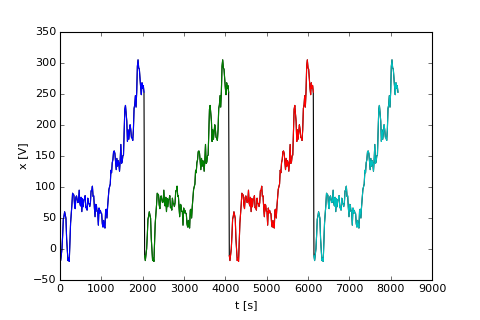

In [53]:
N= 128; T = 2048.; dt = T/N
np.random.seed(seed=456)
x=np.cumsum(np.random.randn(N)*dt)
t = np.arange(0,T,dt)
tt=[]; xx=[]
for ind in range(4):
    tt=np.hstack((tt,t+ind*T))
    xx=np.hstack((xx,x))
fig,ax=plt.subplots(1,1)
ax.plot(tt,xx,'k')
for ind in range(4):
    ax.plot(t+ind*T,x);
ax.set_xlabel('t [s]');ax.set_ylabel('x [V]')

There is a large discontibuity at $t=T=2048 s$.  This discontibuity shows up in the spectra.  Similarly if we consider a sine wave:

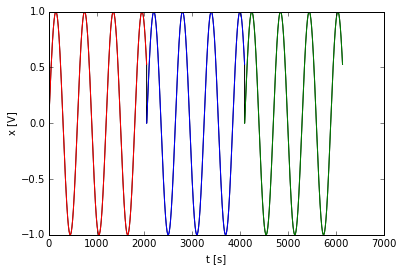

In [12]:
N= 2049;T = 2048.;dt = T/N;om = 2*np.pi/600.
t = np.arange(0,T,dt);x=np.sin(om*t)
tt=[];xx=[]
for ind in range(3):
    tt=np.hstack((tt,t+ind*T))
    xx=np.hstack((xx,x))
fig,ax=plt.subplots(1,1)
ax.plot(tt,xx,'k');ax.plot(t,x,'r');ax.plot(t+T,x,'b');ax.plot(t+T*2,x,'g')
ax.set_xlabel('t [s]');ax.set_ylabel('x [V]')

Again the discontiuty at $t=T$ is  going to show up in our spectral estimation. 

For the single frequency, lets consider the raw periodigram of the signal. 

*NOTE: below we will define a function to do the raw periodigram steps outlined above.*

In [54]:
def rawperio(x,fs):
    dt=1./fs
    N = len(x)
    T = N*dt
    X = dt*np.fft.fft(x)
    G = (2./T)*np.real(np.conj(X[:N/2])*X[:N/2])
    f= np.arange(N/2)/T
    return G[1:],f[1:]

<IPython.core.display.Javascript object>


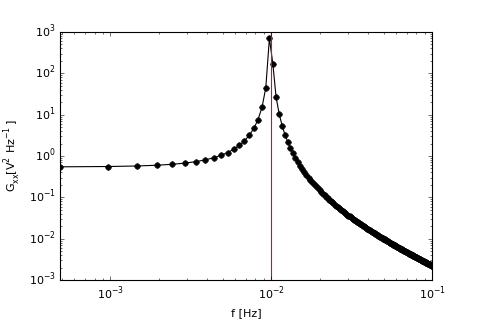

In [56]:
N= 2049;T = 2048.;dt = T/N;
f=np.arange(N/2)/T
df=1./T
f0=f[20]+df/3.
om = 2*np.pi*(f0)
t = np.arange(0,T,dt)
x=np.sin(om*t)
G,f=rawperio(x,1./dt)
fig,ax=plt.subplots(1,1)
ax.loglog(f,G,'k.',markersize=10)
ax.loglog(f,G,'k')
ax.plot(np.array([1,1])*f0,[1e-4,1e4],'r')
ax.set_ylim([1e-3,1000.]);ax.set_xlim([min(f),0.1])
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_{xx} [V^2 Hz^{-1}]$')

The peak is well-defined, but there is substantial energy at frequencies that are off the peak.  These roll off, but in some applications this roll-off may not be fast enough.  This is what is meant by "spectral leakage".

### Leakage derived analytically

We can derive the effect of a finite sample of length $T$ analytically if we think about it as a window from $t=0$ to $T=1$ on an infinite time series.  So, suppose we have a signal $x(t)$ that exists for all $t$, then the periodigram just looks at a shorter signal $x_T(t)$:

\begin{equation}
    x_T(t) = u_T(t)x(t)
\end{equation}

where $u_T(t)=1$ when $0\leq t\leq T$, and $u_T(t)=0$ otherwise.

Taking the Forurier transform and using the convolution theorem  yields

\begin{equation}
    X_T(f) = U_T(f)\star X(f)
\end{equation}

or that the Fourier transform is the true Fourier transform convolved with the Fourier transform of the window.  $U_T(f)$ is easy to compute:

\begin{align}
    U_T(f)&= \int_{-\infty}^{\infty} \mathrm{e}^{-j2\pi f t} \mathrm{d}t\\
    &= \int_0^T \mathrm{e}^{-j2\pi f t} \mathrm{d}t\\
    &= T\mathrm{e}^{-j\pi fT} \int_{-1/2}^{1/2} \mathrm{e}^{-j2\pi fT t'} \mathrm{d}t' \\
    &= T\mathrm{e}^{-j\pi fT} \frac{\mathrm{sin}(\pi fT)}{\pi fT}
\end{align}

where we said that $t'=t/T-1/2$.  This ratio comes up a lot, and therefore we write:

\begin{align}
    U_T(f)&= T\mathrm{e}^{-j\pi fT} \mathrm{sinc}\left( fT\right)
\end{align}

So what happens for our sine wave above?  This has a Fourier transform of $X(f)=\delta(f-f_0)$, so the Fourier transform is $X_T(f)=T\mathrm{e}^{-j\pi (f-f_0) T} \mathrm{sinc}\left( (f-f_0)T\right)$, or the power spectral density is 

\begin{equation}
    S_{xx}(f,T)=\frac{T}{2}\ \mathrm{sinc}^2\left((f-f_0)T\right)
\end{equation}

Note that 

\begin{equation}
    \int_{-\infty}^{\infty} S_{xx}\ \mathrm{d}f = \frac{1}{2}
\end{equation}

which is the variance of a sine wave.  The sinc function has zeros at $f-f_0=nT$ where $n$ is any integer not equal to zero.  

NOTE: different people define "sinc" differently, usually with or without the $\pi$ as an argument.  Numpy's `np.sinc` uses the definition here:

\begin{equation}
    \mathrm{sinc}(x)=\frac{\sin(\pi x)}{\pi x}
\end{equation}


<IPython.core.display.Javascript object>


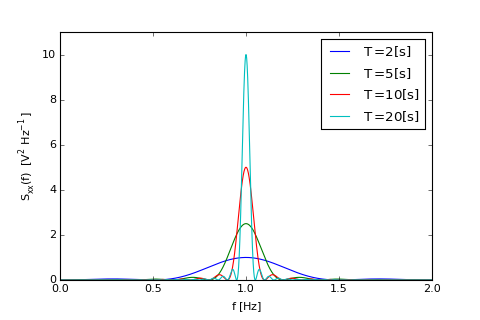

In [57]:
f0=1.
fig,ax=plt.subplots(1,1)
f=np.linspace(-20.,20.,100000)
for T in [2,5,10,20]:
    thesinc=T*np.sinc((f-f0)*T)**2/2.
    df = np.median(np.diff(f))
    ax.plot(f,thesinc,label='$T=%d [s]$'%T)
ax.set_xlim([0,2]);ax.set_ylim([0,11]);ax.legend()
ax.set_xlabel('$f\ [Hz]$');ax.set_ylabel('$S_{xx}(f)\ \ [V^2 Hz^{-1}]$')

This is the effect of calculating the power spectrum of a finite time series. There is nothing about discretizing the time series in here yet. Note that as $T$ gets larger, the power spectrum more closely approaches a delta function, with the "sidelobes" closer to fundamental peak, and the fundamental peak gets much taller. The fundamental peak is $T/2$ high. 

The "sidelobes" are the subsidiary peaks on either side of the main peak.  These sidelobes are highest at when $\left|\sin(\pi (f-f_0)T)\right|\approx 1$, or when 
$f-f_0\approx\frac{2n+1}{2T}$, *except* for the first time, which is burried in the roll off, so $\left|n\right|>0$.  The sidelobe amplitudes are approximately 

\begin{equation}
    2T\left(\frac{1 }{\pi (2n+1)}\right)^2
\end{equation}

or $4/\left(\pi (2n+1)\right)^2$ of the peak height.  So the first sidelobe, $n=1$ is $0.045$ of the peak value, or $10\mathrm{log}_{10}(0.045)=-13.5$ dB.  The second side lobe is at $n=2$, or $f-f_0 \approx \frac{5}{2T}$ and is $0.016$ of the peak or -18 dB.

These sidelobes explain the energy that leaks into the frequencies around the peak as shown below:

<IPython.core.display.Javascript object>


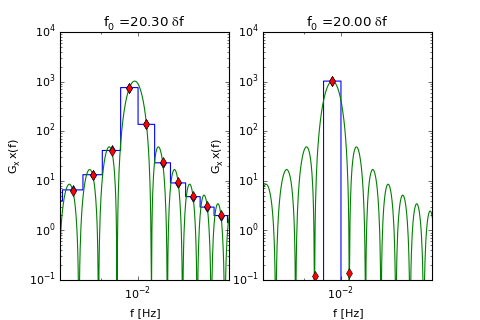

In [60]:
N= 2049;T = 2048.;dt = T/N;
fig,axs=plt.subplots(1,2)

for ind,ax in enumerate(axs):
    f=np.arange(N/2)/T
    df=1./T
    if ind==0:
        om = 2*np.pi*(f[20]+0.3*df)
    else:
        om = 2*np.pi*(f[20])
    t = np.arange(0,T,dt);    x=np.sin(om*t)
    G,f=rawperio(x,1./dt)
    ax.loglog(f,G,'db')
    ax.step(f,G,where='mid');
    f0=om/2./np.pi
    ff=np.logspace(-4,1,10000)
    thesinc=T*np.sinc((ff-f0)*T)**2/2.
    ax.loglog(ff,thesinc);
    localsinc=np.interp(f,ff,thesinc)
    ax.loglog(f,localsinc,'d')
    ax.set_xlim([8e-3,1.3e-2]);ax.set_ylim([1.e-1,1e4]);    ax.set_title('$f_0= %1.2f\ \delta f$'%(f0/df))
    ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_xx(f)$')

Here we see that the discrete periodigram we calculate is projected onto the sinc function at the frequencies $f_k = k\delta f$.  Usually this leads to off-peak frequencies having spectral energy.  A special case occurs when the frequency of the sine wave $f_0$ is an integer multiple of the periodigram frequency spacing $\delta f$.  In that case, shown above on the right, the periodigram just has one peak because the off-peak entries are at the nulls in the periodigram.  

In the case on the left, we might not mind the central two frequency bins splitting the energy of the sine wave.  After all, the true frequency lies between them.  However, we might mind the lobes to the left and the right, as they may obscure other peaks or a background continuum spectrum. 

In the example below, our spectrum consists of two peaks and some background noise.  The peak at the lower frequency is considerably smaller.

<IPython.core.display.Javascript object>


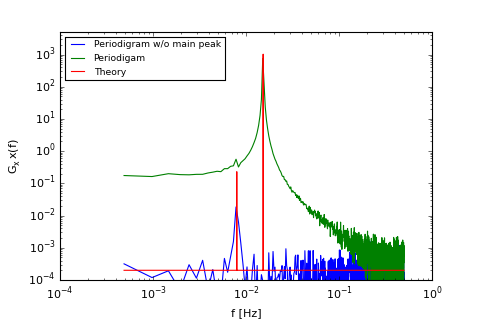

(0.0001, 5000.0)

In [66]:
t = np.arange(0,T,dt); 
om1 = 2*np.pi*(f[30]+0.3*df)
om2 = 2*np.pi*(f[15]+0.3*df)
x=np.sin(om1*t)+0.005*np.sin(om2*t+0.1)+np.random.randn(len(t))/100.
G,f=rawperio(x,1./dt)
xback=0.*np.sin(om1*t)+0.005*np.sin(om2*t+0.1)+np.random.randn(len(t))/100.
Gg,f=rawperio(xback,1./dt)
df=np.median(np.diff(f))
fig,ax=plt.subplots(1,1)
ax.loglog(f,Gg,label='Periodigram w/o main peak')
ax.loglog(f,G,label='Periodigam')
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_xx(f)$')
ff = np.logspace(np.log10(f[0]),np.log10(f[-1]),10000)
theory = 0*ff+1./100.**2/f[-1]
ind = np.where(ff>=om1/2./np.pi)[0][0]
theory[ind]=0.5/df
ind = np.where(ff>=om2/2./np.pi)[0][0]
theory[ind]=0.5/df*0.015**2
ax.loglog(ff,theory,label='Theory')
ax.legend(loc=2,fontsize='small')
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_xx(f)$');ax.set_ylim([1e-4,0.5e4])

The weaker peak is definitely well above the "noise" of our process, but is obscured by the sidelobe leakage from the dominant peak in the green curve.

The solution to this problem is to smooth out the discontibuities at the edge of the spectrum by applying a window that makes the edge of the window go to zero.  

## Windows to reduce sidelobe leakage

So the solution is to apply a window that reduces the sidelobe leakage.  Here we apply the Hanning window:

\begin{equation}
    w(n)=0.5\left(1-\cos \left(\frac{2\pi n}{N-1} \right) \right)
\end{equation}

where $n=0,1...N-1$, and $N$ is the length of the time series.  Before describing it, lets see the effect on the powerspectrum calculated above:

<IPython.core.display.Javascript object>


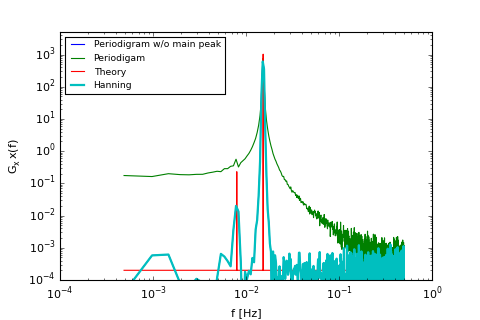

In [69]:
fig,ax=plt.subplots(1,1)
ax.loglog(f,Gg,label='Periodigram w/o main peak'); ax.loglog(f,G,label='Periodigam'); ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_xx(f)$')
ff = np.logspace(np.log10(f[0]),np.log10(f[-1]),10000)
ax.loglog(ff,theory,label='Theory')
ax.legend(loc=2,fontsize='small')
ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_xx(f)$');ax.set_ylim([1e-4,0.5e4])
han0 = 0.5*(1-np.cos(2*np.pi*np.arange(0,N)/(N-1)))
han = han0/np.sqrt(np.sum(han0**2/N))
Gg,f=rawperio(x*han,1./dt)
ax.loglog(f,Gg,'c',linewidth=2,label='Hanning')
ax.legend(loc=2,fontsize='small')

We see that the sidelobe leakage is *greatly* reduced, and the smalled peak is clearly discernable.  Furthermore, the background noise level (the flat line) is clear in this spectrum as well.  

The raw periodigram is basically applying a boxcar window to the infinite time series, and the windowed periodigram is applying a more tapered window.  Note that the Hanning window tapers to zero at the ends.  This gets rid of the discontinuities in the implied time series:

<IPython.core.display.Javascript object>


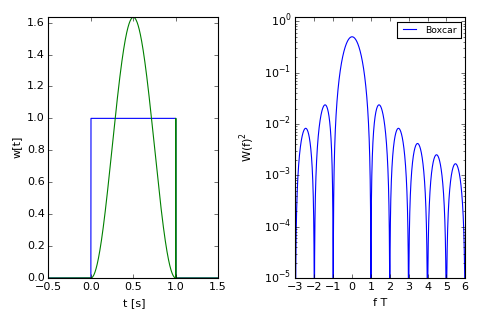

In [81]:
def plotit():
    # convenience so we can replot below
    T=1.;N=2048;dt=T/N;f0=0
    fig,axs=plt.subplots(1,2)
    ax=axs[0]
    tt=np.arange(-0.5*T,1.5*T,dt);xx = 0*tt;xx[(tt>=0)&(tt<=T)]=1.
    ax.plot(tt,xx)
    wind = 0.5*(1-np.cos(2*np.pi*np.arange(0,N)/(N-1)));wind = wind/np.sqrt(np.sum(wind**2/N))
    xx[(tt>=0)&(tt<T)]=wind
    ax.plot(tt,xx)
    ax.set_xlabel('t [s]');ax.set_ylabel('w[t]');ax.axis('tight')

    ax=axs[1]
    f=np.linspace(-3./T,6./T,100000)
    thesinc=T*np.sinc((f-f0)*T)**2/2.
    ax.semilogy(f,thesinc,label='Boxcar')
    ax.legend(loc=1,fontsize='small')
    ax.set_ylim([1e-0,1.5e3]);ax.set_ylabel('$W(f)^2$');ax.axis('tight');ax.set_ylim([1e-5,1.2]);ax.set_xlabel('f T');plt.tight_layout()
    return fig,ax
fig,ax=plotit()

Note that in order for the windowed time series to have the same variance as the raw, we need to scale the window so that it has the same root-mean-squared value as the boxcar window, so:
\begin{equation}
    \sum_{i=0}^{N-1} w'^2(n) = \sum_{i=0}^{N-1} a w^2(n) = N.
\end{equation}
Therefore
\begin{equation}
    a = N\left(\sum_{i=0}^{N-1} w^2(n)\right)^{-1}
\end{equation}
normalizes the window properly, as shown above.

The FFT of $w(t)$ is given by 
\begin{equation}
    W_H(f) = \frac{1}{2}W\left(f\right) - \frac{1}{4}W\left(f-\frac{1}{T}\right)- \frac{1}{4}W\left(f+\frac{1}{T}\right)
\end{equation}
where $W(f)$ is the boxcar's Fourier transform as above:
\begin{equation}
    W(f) = T\frac{\sin\left(\pi f T\right)}{\pi f T} \mathrm{e}^{-j\pi fT}
\end{equation}
From this we can calculate the response of a delta function to the window operation:

<IPython.core.display.Javascript object>


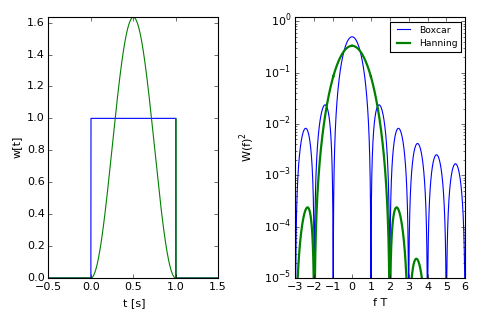

/Users/jklymak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/Users/jklymak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


(1e-05, 1.2)

In [83]:
fig,ax=plotit() # replot plot above
def W(f,T):
    return T*np.sin(f*T*np.pi)/(np.pi*f*T)*np.exp(-1j*np.pi*f*T)
f0=0.
Wh = 0.5*W(f-f0,T)+0.25*T*np.sin(np.pi*(f-1./T)*T)/(np.pi*(f-1./T)*T)*np.exp(-1j*np.pi*f*T)+0.25*T*np.sin(np.pi*(f+1./T)*T)/(np.pi*(f+1./T)*T)*np.exp(-1j*np.pi*f*T)
ax.semilogy(f,Wh*np.conj(Wh)/T*4/3,'g',linewidth=2,label='Hanning')
ax.legend(loc=1,fontsize='small')
ax.set_ylim([1e-5,1.2])


There are two things to note here.  The main lobe of the Hanning window is wider that the main lobe of the boxcar.  Conversely, the sidelones are considerably lower, by over a factor of 20 (it is 30dB down, rather than 13 dB), and they fall off considerably more rapidly with distance from the main lobe. That explains why in the manufactured example above, the smaller peak is better represented, and the noise continuum agrees with the expected value.  

There are many other windows, though the Hanning window is "standard" in a lot of packages.  For a decent list, look at [http://en.wikipedia.org/wiki/Window_function](http://en.wikipedia.org/wiki/Window_function).

To summarize: 
  - It is usual to "taper" the time series to smoothly go to zero at the begining and end in order to reduce spectral leakage.  
  - If you want the power spectrum to have the correct amplitude, you need to normalize the window so that 
   $\frac{1}{N}\sum_{i=0}^{N-1} w'^2(n) = 1$.
   
The pro of windowing:
  - reduce spectral leakage.

The cons:
  - peaks are widened to two adjacent frequencies.
  - you reduce the importance of some of the data.

## Overlapping block averaging

Finally, we can argue why block-averaging has an advantage over frequency-averaging.  If we apply a tapering window, it removes information at the edges of the time series, or the edges of the blocks.  If we overlap the windowed blocks, we can recover some of that lost variance and increase our degrees of freedom.  For the Hanning window, the usual procedure is 
  
  1. delineate blocks that overlap by 50%
  2. window the blocks
  3. take the FFT and compute the power spectrum
  4. average the blocks.
  
The 50% overlap produces almost twice as many blocks, and those blocks are (almost) independent of each other, so more of the underlying variance of the process is captured, increasing the degrees of freedom relative to non-overlapped blocks.  

To see how this works consider a time series that has N=2048, and take FFT blocks that are $N_{FFT}=256$ long.  For the non-overlapped periodigram this yields 8 independent periodigrams, or 16 degrees of freedom.  If we window and overlap by 50%, this yields 15 independent periodigrams. 

We illustrate this below:

<IPython.core.display.Javascript object>


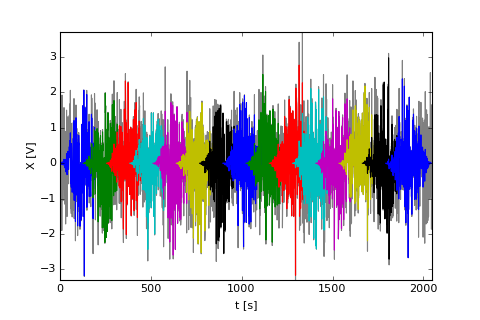

In [85]:
N = 2048
Nfft = 256
wind = 0.5*(1-np.cos(2*np.pi*np.arange(0,Nfft)/(Nfft-1)))
x = np.random.randn(N)
xwind = 0.*x
Nblock = 2*N/Nfft-1
fig,ax=plt.subplots(1,1)
ax.plot(x,color='0.5')
vv=0
for ind in range(Nblock):
    inds = range(ind*Nfft/2,(ind+2)*Nfft/2)
    xwind[inds]=x[inds]*wind
    ax.plot(inds,xwind[inds])
    vv=vv+sum(xwind[inds]**2)
ax.axis('tight');ax.set_xlabel('t [s]');ax.set_ylabel('X [V]')


Here the overlapping windows are coloured.  The underlying time series in in grey.  You can see the tapering to zero at the edges, and the enhancement of variance towards the center.  

Back to our example time series, we can see the effect of some block averaging:

<IPython.core.display.Javascript object>


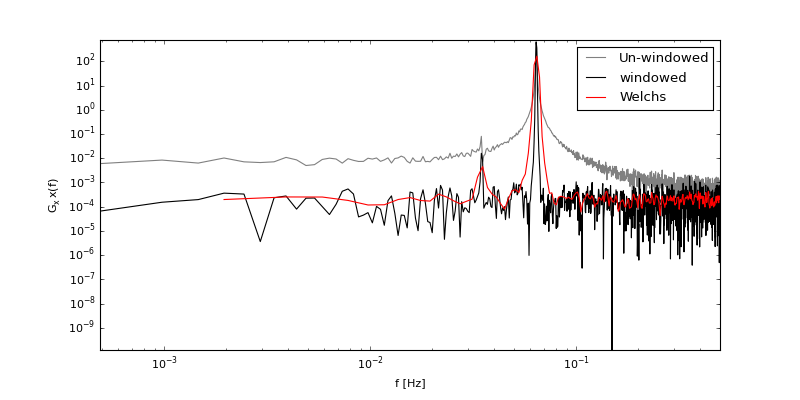

In [98]:
def plotit(f):
    N= 2049;T = 2048.;dt = T/N;
    t = np.arange(0,T,dt); 
    om1 = 2*np.pi*(f[130]+0.3*df)
    om2 = 2*np.pi*(f[70]+0.3*df)
    x=np.sin(om1*t)+0.005*np.sin(om2*t+0.1)+np.random.randn(len(t))/100.
    G,f=rawperio(x,1./dt)
    han0 = 0.5*(1-np.cos(2*np.pi*np.arange(0,N)/(N-1)))
    han = han0/np.sqrt(np.sum(han0**2/N))
    Gwind,f=rawperio(x*han,1./dt)

    fig,ax=plt.subplots(1,1,figsize=(10,5))
    ax.loglog(f,G,color='0.5',label='Un-windowed')
    ax.loglog(f,Gwind,color='k',label='windowed')

    Nfft = 512
    Nblock = 2*N/Nfft-1
    Gbl=0
    wind = 0.5*(1-np.cos(2*np.pi*np.arange(0,Nfft)/(Nfft-1)))
    wind = wind/np.sqrt(np.sum(wind**2/Nfft))
    for ind in range(Nblock):
        inds = range(ind*Nfft/2,(ind+2)*Nfft/2)
        xwind=x[inds]*wind
        Gwind,fbl=rawperio(xwind,1./dt)
        Gbl=Gbl+Gwind
    Gbl = Gbl/Nblock
    ax.loglog(fbl,Gbl,color='r',label='Welch''s')
    ax.legend(loc=0);ax.set_xlabel('f [Hz]');ax.set_ylabel('$G_xx(f)$');
    ax.axis('tight')
    return fig,ax,x
fig,ax,x=plotit(f)

Therefore, the variance in the estimate has dropped (as can be plainly seen by the variance of the flat or "white" part of the spectrum), at the expense of the resolution of the peaks.  The bias induced by sidelobe leakage has been taken care of. 

One practical consideration is what to do if the time series length is not an even multiple of the block length.  In this case two approaches are valid.
  
  1. zero-pad the last block that is not full.  Note that this should be applied *after* windowing, or you will have a disconuity in your time series.
  2. Adjust the windows to fit inside the data by having the overlap be more than 50%.  

### Error bars, or distribution of the estimates

This gets quite difficult when we start adding blocks and windows to the mix.  First, if there is no windowing and no overlap, then the degrees of freedom is simply $\nu=2N_{block}$.  If these unwindowed blocks were overlapped by 50%, then the degrees of freedom would *not* increase because there is no new information added to the spectral estimate.  

If there is windowing, and no overlapping, then the theoretical degrees of freedom decrease, because less information is included in the spectral estimate.  For the Hanning window, instead of 2 degrees of freedom per block, there is approximately 9/11 degrees of freedom per block, which is a substantial drop.  However, because the Hanning window loses information at its edges, 50% overlapped blocks are almost etirely independent, and since there are more overlapped sections, overlapped Hanning estimates have only 25% more variance than un-overlapped un-windowed blocks. 

To summarize: if $\hat{G}_{xx}(f)$ is the one-sided power spectrum made from avaraging $N_{blocks}$, then it has $\nu\approx 2N_{blocks}$ degrees of freedom (with an adjustment for windowing). The real power sectrum multiplied by the degrees of freedom, $G_{xx}(f)\nu/2$, is distributed approximately as $\chi^2_{\nu}$. 

### Canned routines

Matplotlib has a nice canned set of routines that calculates the powerspectra.  To mimic the procedure above you need to specify the window and the overlap. 

<IPython.core.display.Javascript object>


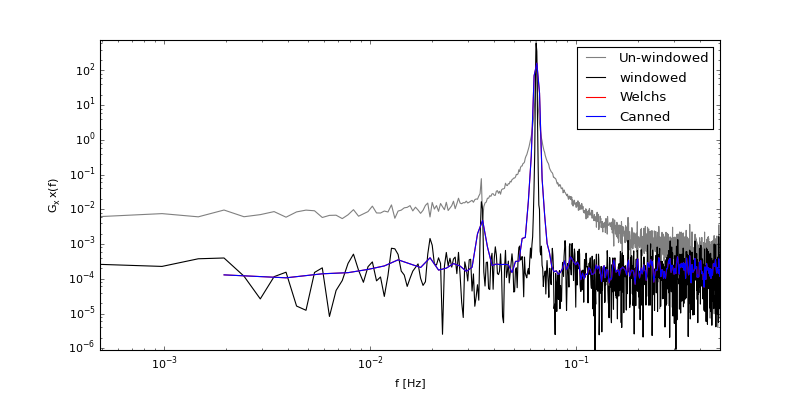

In [99]:
fig,ax,x=plotit(f)
import matplotlib.mlab as mlab
Gcanned,fcanned = mlab.psd(x,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)
ax.loglog(fcanned,Gcanned,'b',label='Canned')
ax.legend(loc=0)


Note that this returns the same result as our by-hand routine.  